# 2/19/20
***
Мне снова задали вопрос о коррелированном отборе, поэтому надо с ним разобраться

In [1]:
import numpy as np
import uproot
import uproot_methods
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplhep as hep
from glob import glob

# %matplotlib inline

# sns.set(rc={'figure.figsize':(13,7)}, font_scale=1.7)
# plt.style.use('seaborn-whitegrid')

# import matplotlib
# matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']

def my_style(title='', xtitle='', ytitle='', gridstyle=':'):
    plt.grid(linestyle=gridstyle)
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    

%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='talk', ticks=True, grid=True, gridlines='--', figsize=(13, 9), fscale=2)

/home/petrov/.local/lib/python3.7/site-packages/mplhep/__init__.py:48: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)


In [2]:
import warnings
warnings.filterwarnings("ignore")

Посмотрю картинки, на которых видно коррелированный отбор

In [11]:
ebeam = 900
mom_tree_exp = uproot.open(glob(f'../../outputs/19/trees/{ebeam}*.root')[0])['pic_mom']
mom_tree_mc = uproot.open(glob(f'../../outputs/model_old_v7/trees/{ebeam}*.root')[0])['pic_mom']

In [15]:
mom_df_exp = mom_tree_exp.pandas.df()
mom_df_mc = mom_tree_mc.pandas.df(flatten=False).query('align>0.8')

In [16]:
p_cut = 2 * (0.0869 * ebeam - 36.53)
p0 = np.sqrt(ebeam**2 - 497.6**2)

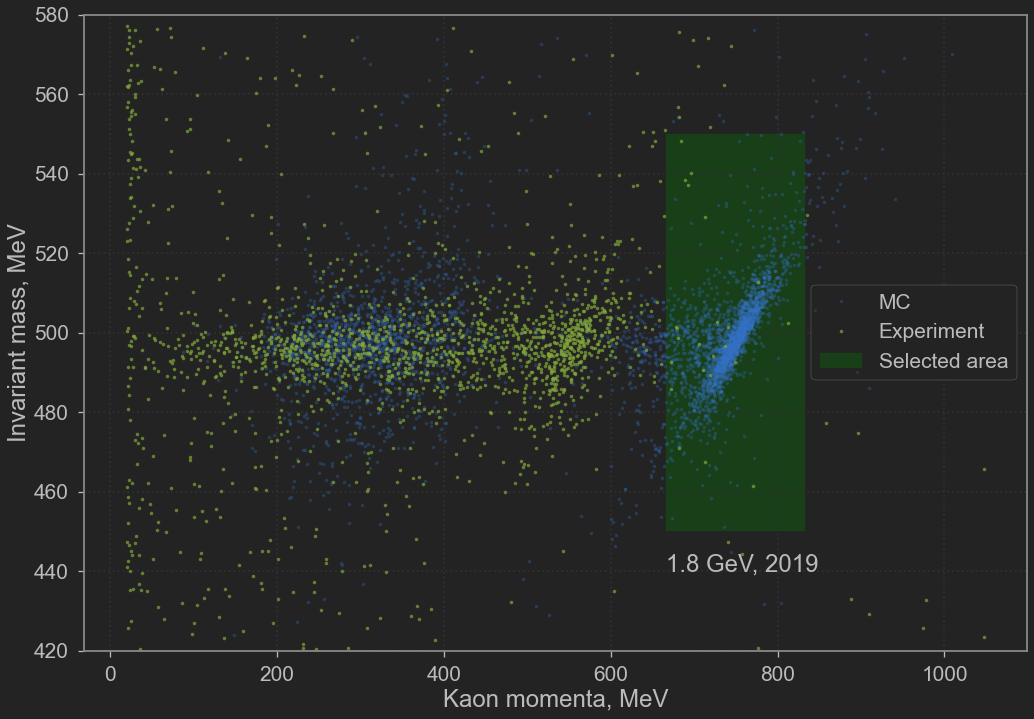

In [17]:
plt.plot(mom_df_mc.momentum, mom_df_mc.mass, '.', label='MC', ms=7, alpha=0.3)#, c='orange')
plt.plot(mom_df_exp.momentum, mom_df_exp.mass, '.', label='Experiment', ms=7, alpha=0.7)#, c='red', alpha=0.7)
plt.fill_between([p0-p_cut, p0+p_cut], [450, 450], [550, 550], color='green', alpha=0.3, label='Selected area')
plt.grid(linestyle=":")
# plt.xlim(50, 350);
plt.ylim(420, 580);
plt.text(p0-p_cut, 440, f"{ebeam*2e-3:.1f} GeV, 2019", size=24);
my_style('','Kaon momenta, MeV','Invariant mass, MeV')
plt.legend(frameon=True);
# plt.savefig(f'outputs/images/7_invMass_mom_dist_19_{ebeam*2e-3:.1f}GeV.png')

Проверяю гипотезу о том, что фон пикуется, для этого
1. Смотрю распределение по импульсу каона, беру сайд-бенды
2. Смотрю как события из сайд-бендов ведут себя на картинке и инвариантной массой

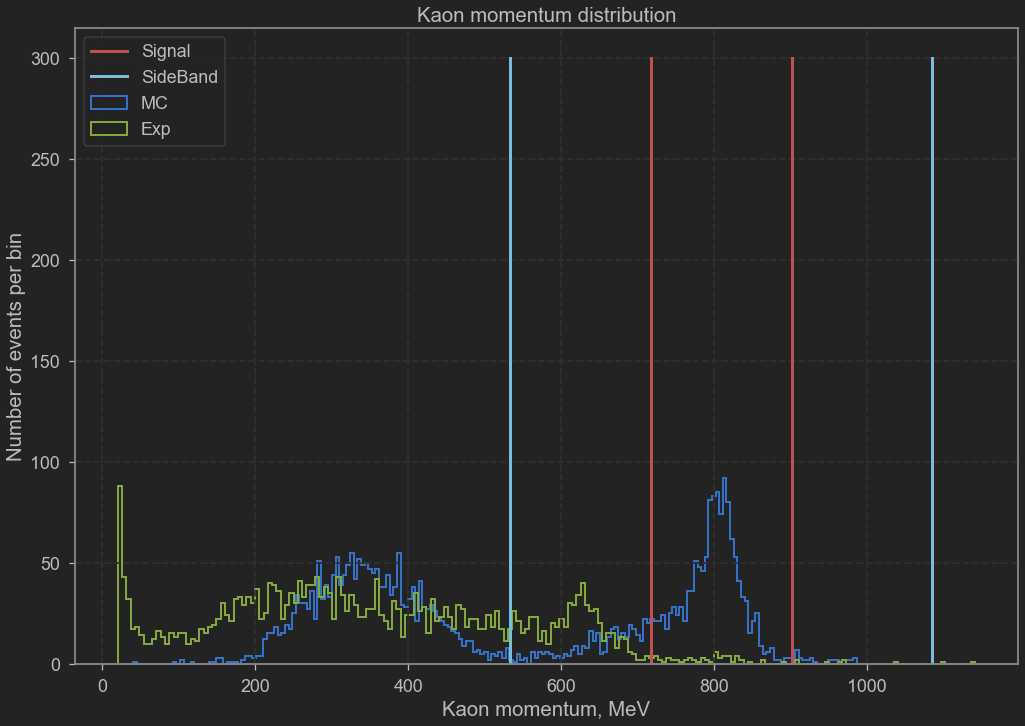

In [54]:
sideband = 3*p_cut
plt.hist(mom_df_mc.momentum, bins=200, histtype='step', lw=2, label='MC');
plt.hist(mom_df_exp.momentum, bins=200, histtype='step', lw=2, label='Exp');
plt.plot([p0-p_cut, p0-p_cut], [0, 300], c='r', lw=3)
plt.plot([p0+p_cut, p0+p_cut], [0, 300], c='r', lw=3, label='Signal')
plt.plot([p0-sideband, p0-sideband], [0, 300], c='c', lw=3)
plt.plot([p0+sideband, p0+sideband], [0, 300], c='c', lw=3, label='SideBand');
plt.legend(frameon=True)
plt.title('Kaon momentum distribution')#'Распределение по импульсу каона\n(проекция предыдущей картинки)')
plt.ylabel('Number of events per bin');
plt.xlabel('Kaon momentum, MeV');
# plt.xlim(100, 500)

In [55]:
sideband_area = dict()
sideband_area['exp'] = mom_df_exp.query('abs(momentum-@p0)<@sideband&abs(momentum-@p0)>@p_cut')
sideband_area['mc'] = mom_df_mc.query('abs(momentum-@p0)<@sideband&abs(momentum-@p0)>@p_cut')

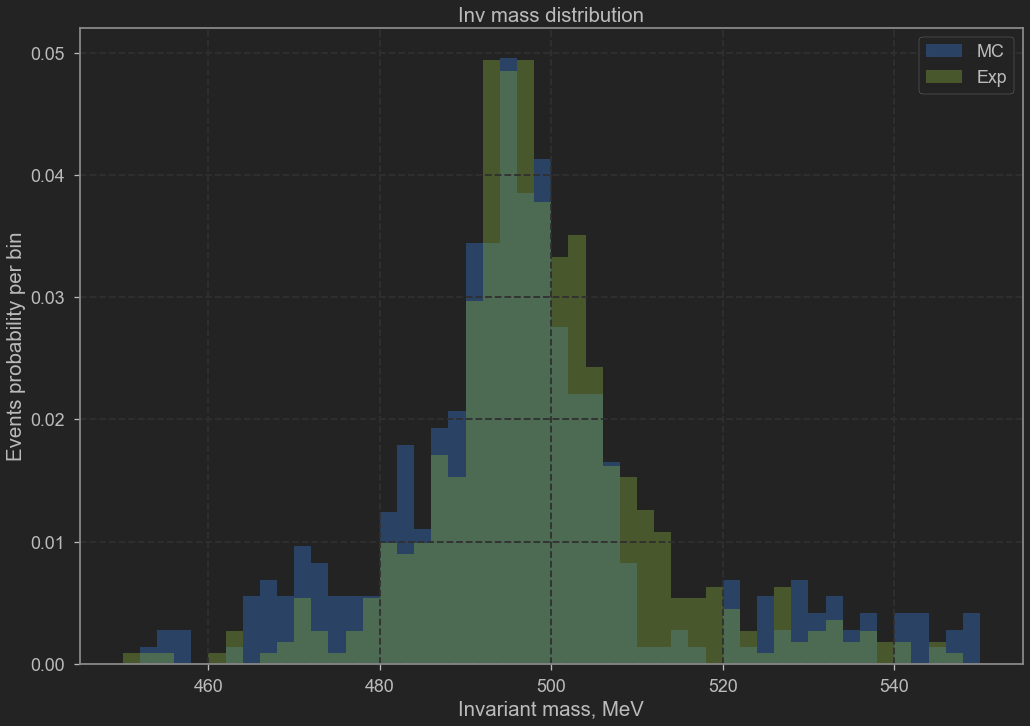

In [56]:
plt.hist( sideband_area['mc'].mass, 
         bins=50, histtype='stepfilled', lw=2, density=True, range=(450, 550), alpha=0.4, label='MC' );
plt.hist( sideband_area['exp'].mass, 
         bins=50, histtype='stepfilled', lw=2, density=True, range=(450, 550), alpha=0.4, label='Exp' );
plt.legend(frameon=True);
plt.title('Inv mass distribution')#Распределение по инвариантной массе\nдля side-band области в импульсном распределении')
plt.xlabel('Invariant mass, MeV');
plt.ylabel('Events probability per bin');

Видно, что в области массы $K_S$ наблюдается пик, однако этот пик также присутствует в моделировании, что говорит о том, что там находятся неотобранные мной $K_S$-мезоны, поэтому это вообще не side-bands и так делать нельзя

*Ради интереса попробую повернуть оси*

In [57]:
cov_matrix = mom_df_mc.query('abs(momentum-@p0)<@p_cut')[['momentum','mass']].cov().values
cov_matrix

array([[1214.94016536,  214.4852194 ],
       [ 214.4852194 ,  149.12110909]])

In [58]:
vP = ( cov_matrix[0,0] )
vM = ( cov_matrix[1,1] )
covMP = cov_matrix[0,1]

phi = (1/2)*np.arcsin( covMP/(vP - vM) )

Угол поворота найден, теперь нужно повернуть координаты

In [59]:
A = np.array([[0.5, 0], [0, 1]])
R = np.array([ [np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)] ] )

In [60]:
A = mom_df_mc[['momentum', 'mass']].values.T
B = mom_df_exp[['momentum', 'mass']].values.T

In [61]:
new_df_mc = pd.DataFrame( np.matmul(R, A).T )
new_df_exp = pd.DataFrame( np.matmul(R, B).T )

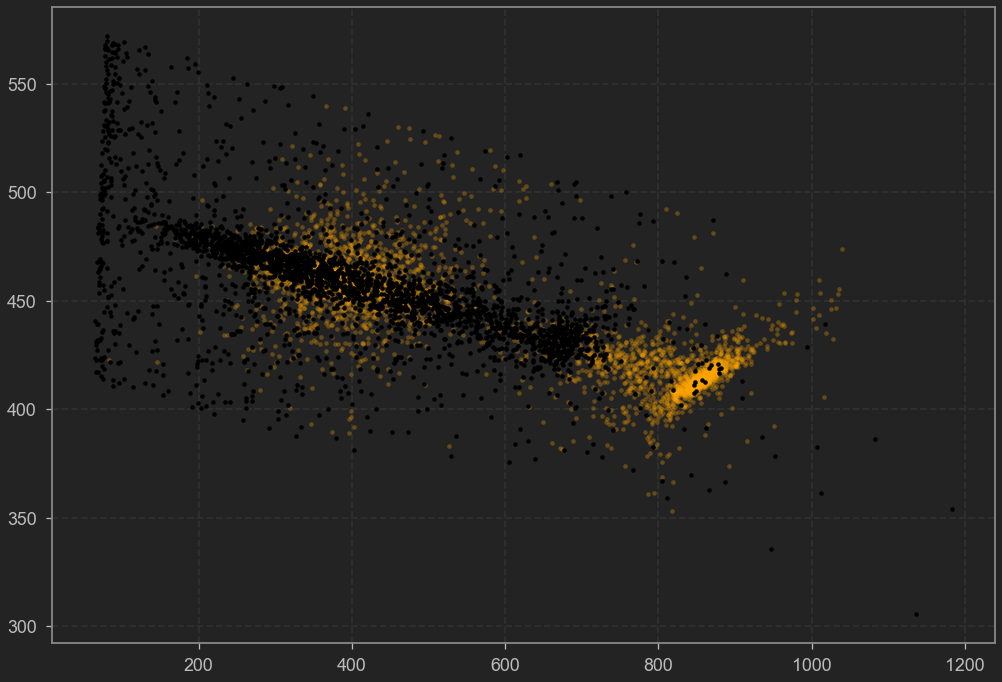

In [64]:
plt.plot(new_df_mc[0], new_df_mc[1], '.', label='MC', alpha=0.3, c='orange')
plt.plot(new_df_exp[0], new_df_exp[1], '.', label='Exp', c='black')

## Аппроксимация одним Гауссом

In [65]:
def fcn_tester():
    a = []
    for _ in range(500):
        data = pf.gen_toy(pf.gaussian, 5000, bound=bound, mean=497.617, sigma=5, quiet=True);
        unbinned_likelihood = pf.UnbinnedLH(pf.gaussian, data);
        minuit = iminuit.Minuit(unbinned_likelihood, mean=497.6, sigma=5);
        minuit.migrad();
        a.append( minuit.fval )
    return a

In [66]:
data = np.random.normal(497.6, 9, 7000)

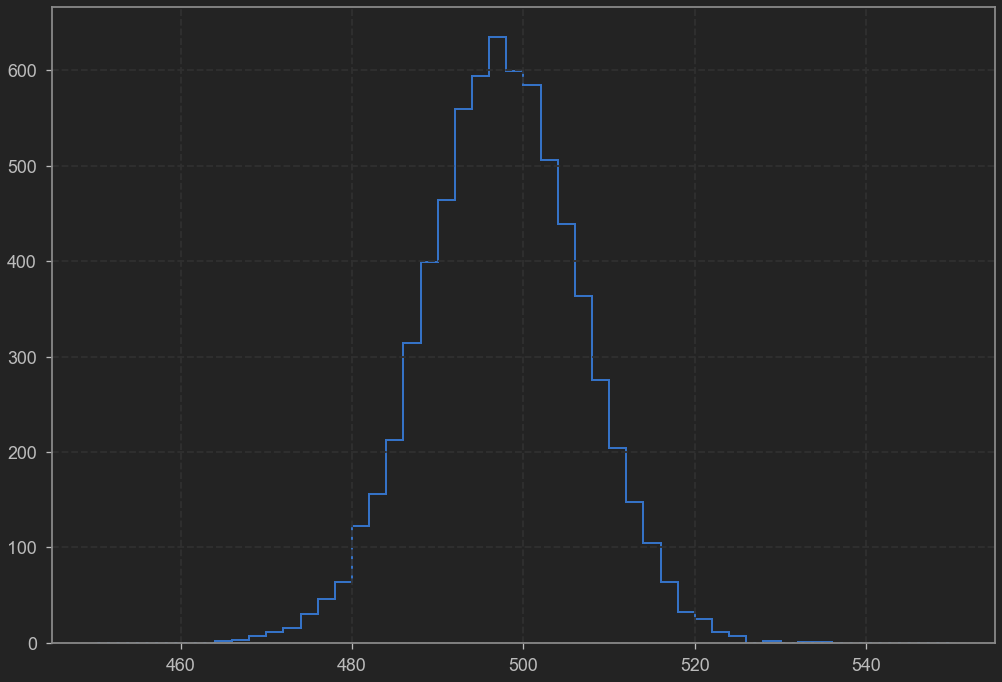

In [67]:
plt.hist(data, bins=50, range=(450, 550), histtype='step', lw=2);

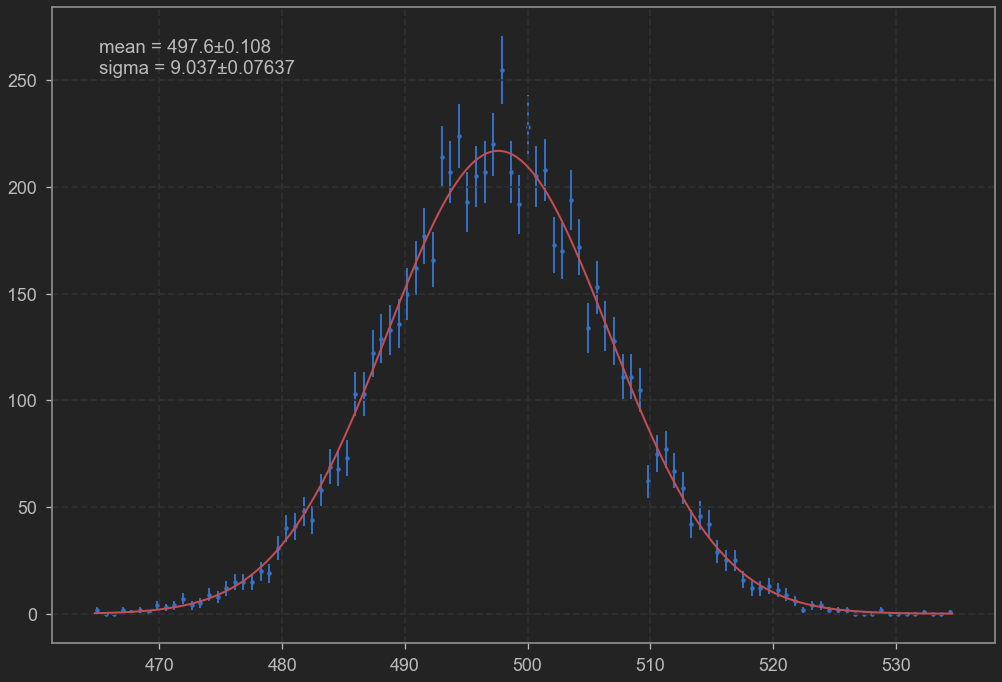

In [68]:
import probfit as pf
import iminuit
unbinned_likelihood = pf.UnbinnedLH(pf.gaussian, data)
minuit = iminuit.Minuit(unbinned_likelihood, mean=497.6, sigma=5);
minuit.migrad();
unbinned_likelihood.draw(minuit);

In [69]:
# np.random.seed(0)
bound = (497.6-40, 497.6+40);
data = pf.gen_toy(pf.gaussian, 5000, bound=bound, mean=497.617, sigma=5, quiet=True);
# plt.grid(linestyle=':');

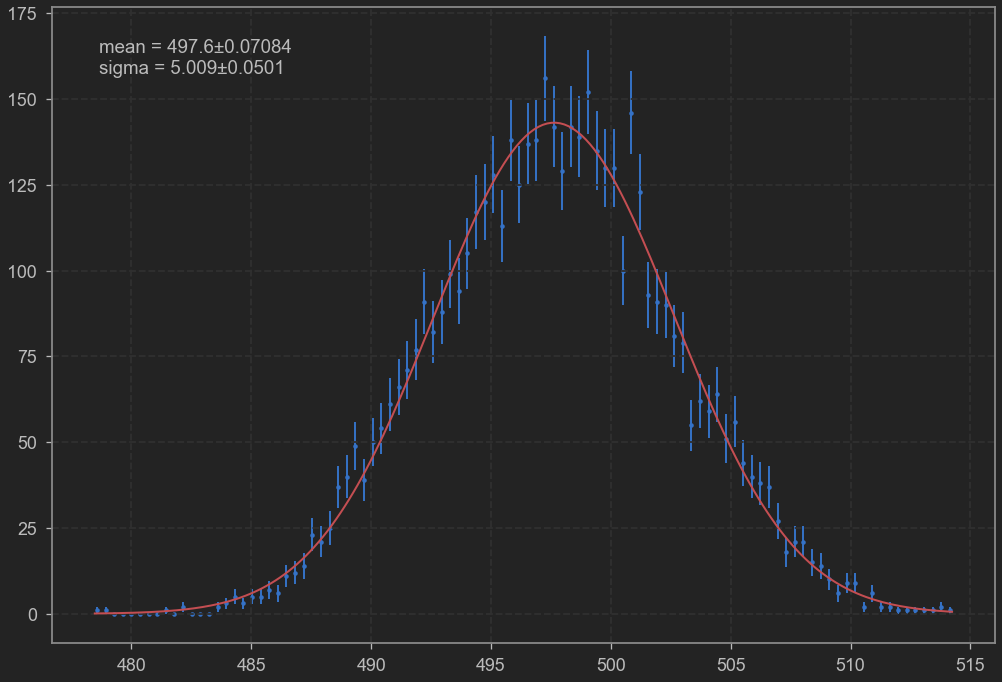

In [70]:
unbinned_likelihood = pf.UnbinnedLH(pf.gaussian, data);
minuit = iminuit.Minuit(unbinned_likelihood, mean=497.6, sigma=5);
minuit.migrad();
unbinned_likelihood.draw(minuit);

In [71]:
minuit.fval

15151.283489027144

In [72]:
a = []
for _ in range(500):
    data = pf.gen_toy(pf.gaussian, 5000, bound=bound, mean=497.617, sigma=5, quiet=True);
    unbinned_likelihood = pf.UnbinnedLH(pf.gaussian, data);
    minuit = iminuit.Minuit(unbinned_likelihood, mean=497.6, sigma=5);
    minuit.migrad();
    a.append( minuit.fval );

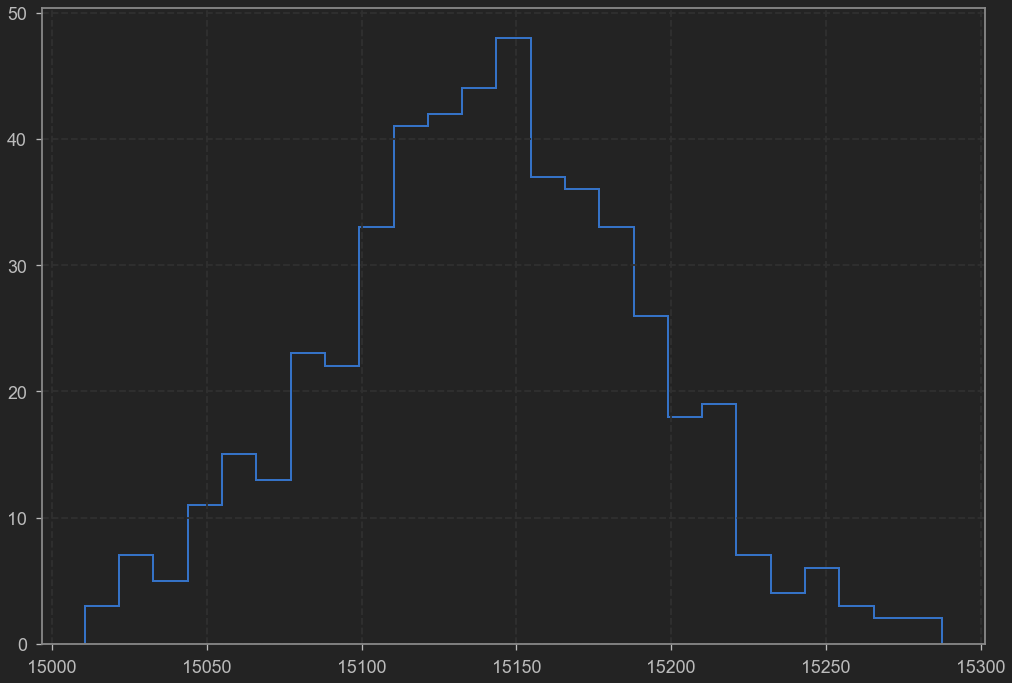

In [74]:
plt.hist(a, bins=25, histtype='step', lw=2);

Добавлю это в файл `Analysis.ipynb`

## Фит. функция  - вторая часть
____
Найду истинные пионы из распада $K_S$ в MC, привяжу их к реконструированным и отстрою инвариантную массу.

In [75]:
def select_charge_df(mc_gen, mc_rec, charge=1):
    mc_gen_plus = mc_gen.query('(simorig==310)&(simtype==211*@charge)').copy().drop(['simorig','simtype'], axis=1).\
               reset_index(level=1, drop=True)
    mc_rec_plus = mc_rec.query('tcharge==@charge')
    mc_plus = mc_rec_plus.merge(mc_gen_plus, on='entry').drop(['tcharge'],axis=1).dropna().\
                            rename({'vec_x':'rec', 'vec_y':'gen'},axis=1)
    mc_plus['diff'] = [ x.angle(y) for x,y in zip(mc_plus.rec.values, mc_plus.gen.values)]
    mc_plus = mc_plus.reset_index()
    mc_plus = mc_plus.loc[ mc_plus.groupby('entry')['diff'].idxmin() ].copy().set_index('entry')
    return mc_plus.query('diff<0.1')

def find_pions_from_ks_decay(mc):
    mc_gen = mc.pandas.df( branches=['emeas', 'simtype', 'simorig', 'simtheta', 'simphi', 'simmom'] )
    mc_gen = vector_creator(mc_gen, 'simmom', 'simtheta', 'simphi').drop(['simmom', 'simtheta', 'simphi'], axis=1)
    
    mc_rec = mc.pandas.df( branches=['nt', 'tth', 'tphi', 'tcharge', 'tptot'] ).query('nt>1').drop(['nt'], axis=1)
    mc_rec = vector_creator(mc_rec, 'tptot', 'tth', 'tphi').drop(['tptot', 'tth', 'tphi'], axis=1)
       
    return select_charge_df(mc_gen, mc_rec, 1), select_charge_df(mc_gen, mc_rec, -1)

def vector_creator(df, p='tptot', th='tth', ph='tphi'):
    df['vec'] = uproot_methods.TVector3Array.from_spherical(df[p], df[th], df[ph])
    return df

def get_df_charged(ks_table, charge=1):
    df_plus = pd.DataFrame( np.where(ks_table['charge[0]']==charge, 
        [ ks_table['kspipt[0]'], ks_table['kspith[0]'], ks_table['kspiphi[0]'] ], 
        [ ks_table['kspipt[1]'], ks_table['kspith[1]'], ks_table['kspiphi[1]'] ] ).T, index=ks_table.index, 
                  columns=['p', 'th', 'phi'] )
    return df_plus

def find_pions_from_ks_decay_corrected(mc):
    mc_gen = mc.pandas.df( branches=['emeas', 'simtype', 'simorig', 'simtheta', 'simphi', 'simmom'] )
    mc_gen = vector_creator(mc_gen, 'simmom', 'simtheta', 'simphi').drop(['simmom', 'simtheta', 'simphi'], axis=1)
    
    ks_table = mc.pandas.df(branches=['kspiphi', 'kspith', 'kspipt', 'kstype', 'ksvind'])
    charge = mc.array(branch=['tcharge'])
    for r in ks_table.iterrows():
        ks_table.at[r[0], 'charge[0]'] = charge[ r[0][0], int(r[1]['ksvind[0]']) ]
        ks_table.at[r[0], 'charge[1]'] = charge[ r[0][0], int(r[1]['ksvind[1]']) ]
    df_plus = get_df_charged(ks_table, 1)
    df_minus = get_df_charged(ks_table, -1)
    
    df_plus = vector_creator(df_plus, 'p', 'th', 'phi').drop(['p','th','phi'], axis=1).reset_index(level=1)
    df_plus['tcharge'] = 1
    
    df_minus = vector_creator(df_minus, 'p', 'th', 'phi').drop(['p','th','phi'], axis=1).reset_index(level=1)
    df_minus['tcharge'] = -1        

    return select_charge_df(mc_gen, df_plus, 1), select_charge_df(mc_gen, df_minus, -1)

In [178]:
mc = uproot.open('/store17/petrov/data/kskl_sim/tr_ph_run004897.root')['tr_ph'] #004880 550 MeV 004910 935 MeV

In [179]:
mc_plus, mc_minus = find_pions_from_ks_decay_corrected(mc) #corrected pions
# mc_plus, mc_minus = find_pions_from_ks_decay(mc) #obvious pions

In [180]:
mc_minus.head()

,subentry,rec,emeas,gen,diff
entry,,,,,
0,0,"TVector3(158.67, 95.466, -71.957)",775.0,"TVector3(156.72, 94.169, -75.797)",0.022367
2,0,"TVector3(174.72, -161.16, 20.644)",775.0,"TVector3(184.21, -167.5, 26.464)",0.020524
3,0,"TVector3(-113.08, 99.57, -64.196)",775.0,"TVector3(-112.66, 98.972, -63.808)",0.001153
4,0,"TVector3(47.412, -432.46, -294.56)",775.0,"TVector3(49.277, -441.01, -296.15)",0.006889
6,0,"TVector3(319.91, -19.83, 94.096)",775.0,"TVector3(310.28, -20.043, 94.348)",0.009402


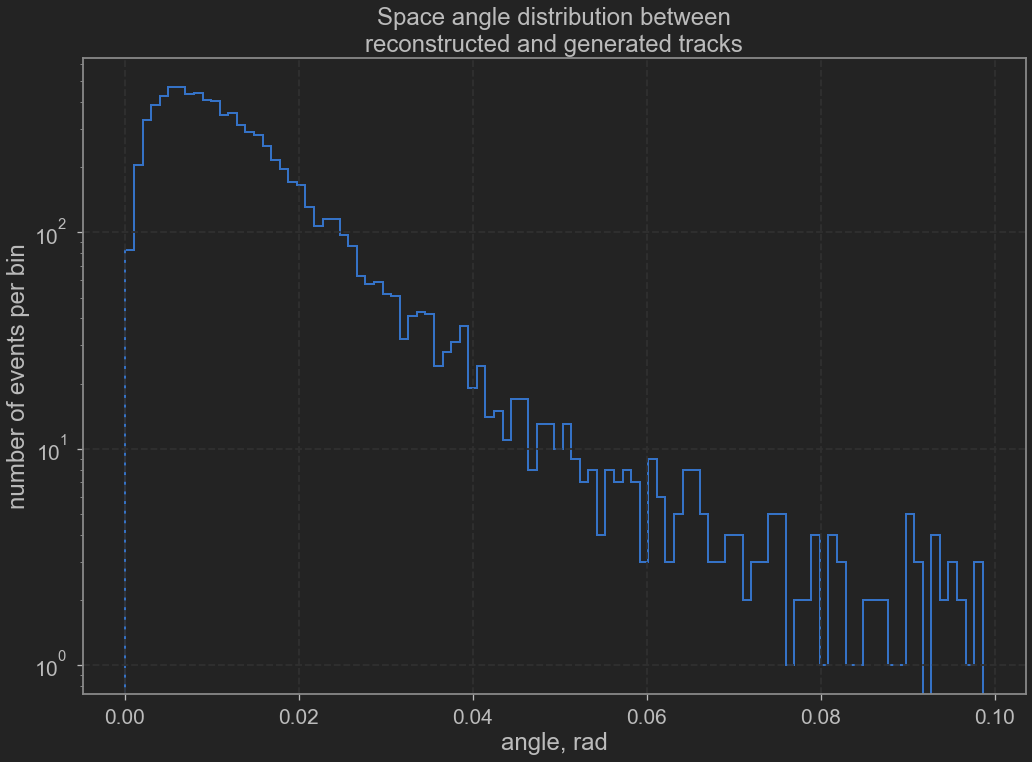

In [181]:
plt.hist( mc_plus['diff'], bins=100, histtype='step', lw=2 );
plt.yscale('log')
my_style('Space angle distribution between\nreconstructed and generated tracks',#'Пространственный угол между реконструированными и\nгенераторными треками после отбора',
         'angle, rad',#'Угол, рад', 
         'number of events per bin',#'Число событий в бине', 
         '--')
# plt.savefig('outputs/images/7_space_angle.png')

In [182]:
mc_minus.head()

,subentry,rec,emeas,gen,diff
entry,,,,,
0,0,"TVector3(158.67, 95.466, -71.957)",775.0,"TVector3(156.72, 94.169, -75.797)",0.022367
2,0,"TVector3(174.72, -161.16, 20.644)",775.0,"TVector3(184.21, -167.5, 26.464)",0.020524
3,0,"TVector3(-113.08, 99.57, -64.196)",775.0,"TVector3(-112.66, 98.972, -63.808)",0.001153
4,0,"TVector3(47.412, -432.46, -294.56)",775.0,"TVector3(49.277, -441.01, -296.15)",0.006889
6,0,"TVector3(319.91, -19.83, 94.096)",775.0,"TVector3(310.28, -20.043, 94.348)",0.009402


In [183]:
def build_decay(mc_plus, mc_minus, merge_field='rec'):
    mP = mc_plus[[merge_field]].rename({merge_field : 'plus'},axis=1)
    mM = mc_minus[[merge_field]].rename({merge_field : 'minus'},axis=1)
    
    merged_table = mP.merge(mM, on='entry')
    merged_table['angle'] = [ x.angle(y) for x,y in zip(merged_table['plus'].values, \
                                                        merged_table['minus'].values)]
    return merged_table

In [184]:
merged_table_rec = build_decay(mc_plus, mc_minus, 'rec')
merged_table_gen = build_decay(mc_plus, mc_minus, 'gen')

In [185]:
merged_table_rec.head()

,plus,minus,angle
entry,,,
0,"TVector3(292.93, 18.944, 340.92)","TVector3(158.67, 95.466, -71.957)",1.301759
2,"TVector3(-179.64, -380.15, 129.1)","TVector3(174.72, -161.16, 20.644)",1.255512
3,"TVector3(167.03, 27.808, 218.15)","TVector3(-113.08, 99.57, -64.196)",2.299692
4,"TVector3(-21.991, -6.7513, 56.215)","TVector3(47.412, -432.46, -294.56)",2.048864
6,"TVector3(212.72, 255.74, -188.86)","TVector3(319.91, -19.83, 94.096)",1.209159


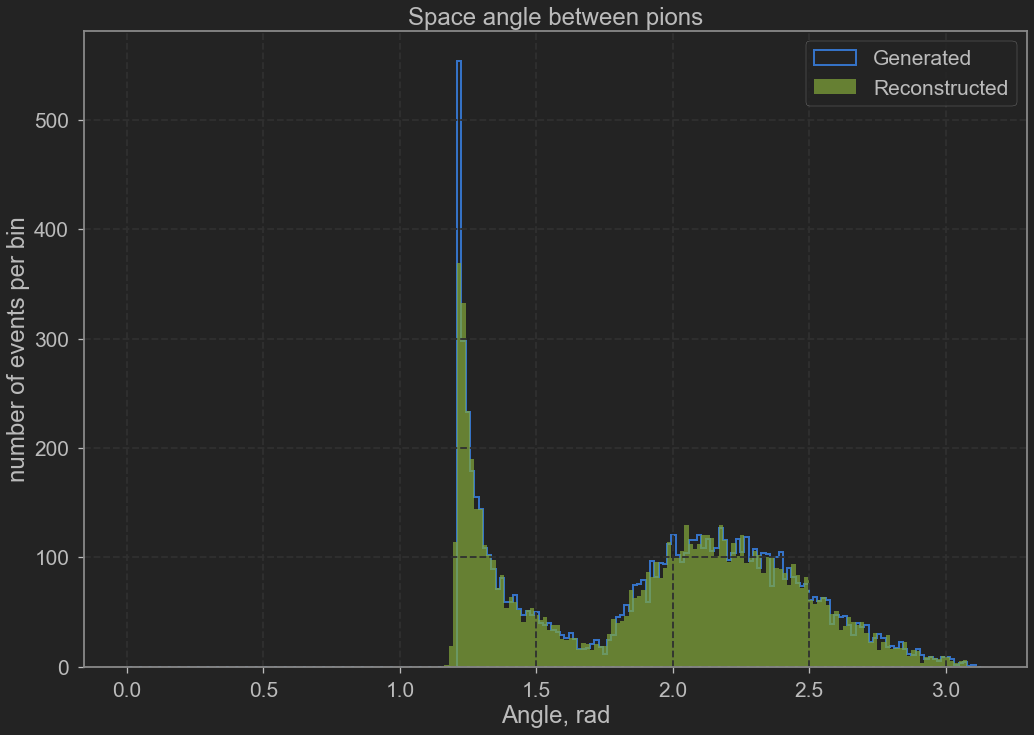

In [186]:
plt.hist( merged_table_gen['angle'], bins=200, histtype='step', lw=2, range=(0,np.pi), label='Generated' );
plt.hist( merged_table_rec['angle'], bins=200, histtype='stepfilled', lw=2, range=(0,np.pi), 
         alpha=0.7, label='Reconstructed' );
plt.legend(frameon=True)
my_style('Space angle between pions',#'Пространственный угол между двумя пионами',
         'Angle, rad',#'Угол, рад', 
         'number of events per bin',#'Число событий в бине', 
         '--')
# plt.savefig('outputs/images/7_space_angle_pions.png')

In [187]:
def vector3_to_vector4( series, mass ):
    coords = np.array(list( map( lambda x: np.array( [x.x, x.y, x.z] ) , series ) ) )
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
    return uproot_methods.TLorentzVectorArray.from_xyzm(x, y, z, mass)
def get_mass_table(df):
    mPi = 139.6
    df = df.copy()
    df['M'] = ( vector3_to_vector4( df.plus, mPi ) + vector3_to_vector4( df.minus, mPi ) ).mass
    return df

In [188]:
vec4_table_rec = get_mass_table(merged_table_rec)
vec4_table_gen = get_mass_table(merged_table_gen)

In [189]:
vec4_table_rec.head()

,plus,minus,angle,M
entry,,,,
0,"TVector3(292.93, 18.944, 340.92)","TVector3(158.67, 95.466, -71.957)",1.301759,469.264675
2,"TVector3(-179.64, -380.15, 129.1)","TVector3(174.72, -161.16, 20.644)",1.255512,478.555122
3,"TVector3(167.03, 27.808, 218.15)","TVector3(-113.08, 99.57, -64.196)",2.299692,482.086908
4,"TVector3(-21.991, -6.7513, 56.215)","TVector3(47.412, -432.46, -294.56)",2.048864,483.593087
6,"TVector3(212.72, 255.74, -188.86)","TVector3(319.91, -19.83, 94.096)",1.209159,493.363443


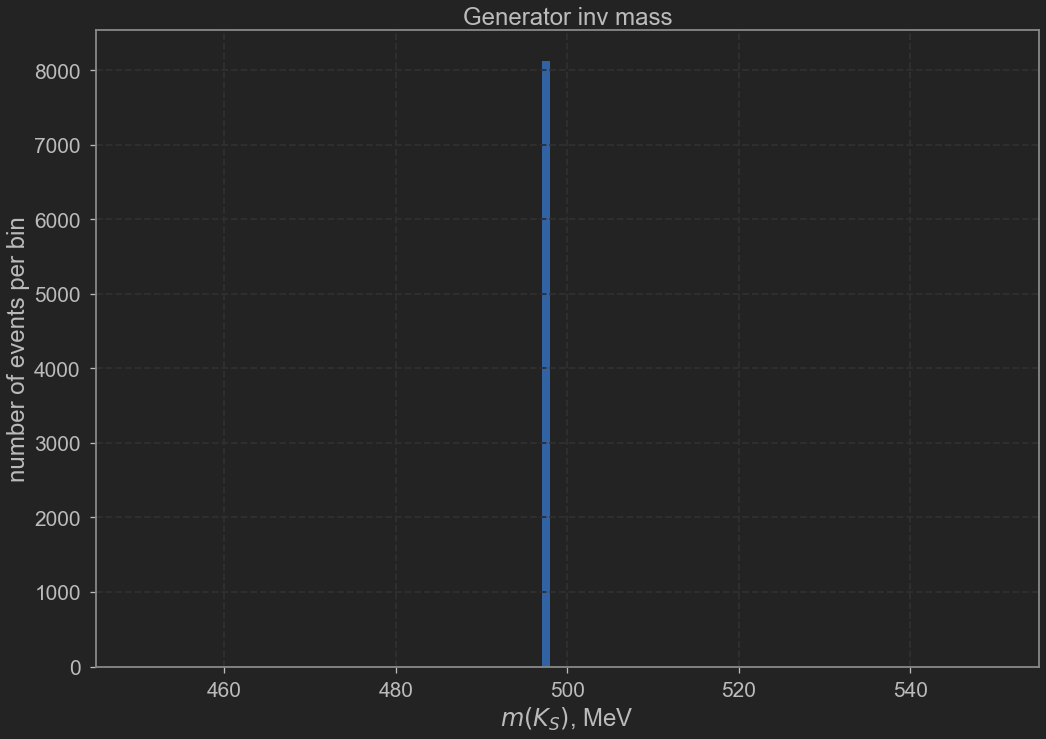

In [190]:
m = vec4_table_gen
plt.hist(m.M, bins=100, range=(450, 550), histtype='stepfilled', alpha=0.8, lw=2);
my_style('Generator inv mass', '$m(K_S)$, MeV', 'number of events per bin', '--');
# plt.savefig('outputs/images/7_gen_K.png')

In [191]:
print('Mean generator inv mass:', m.M.mean(), 'MeV')

Mean generator inv mass: 497.65035663481206 MeV


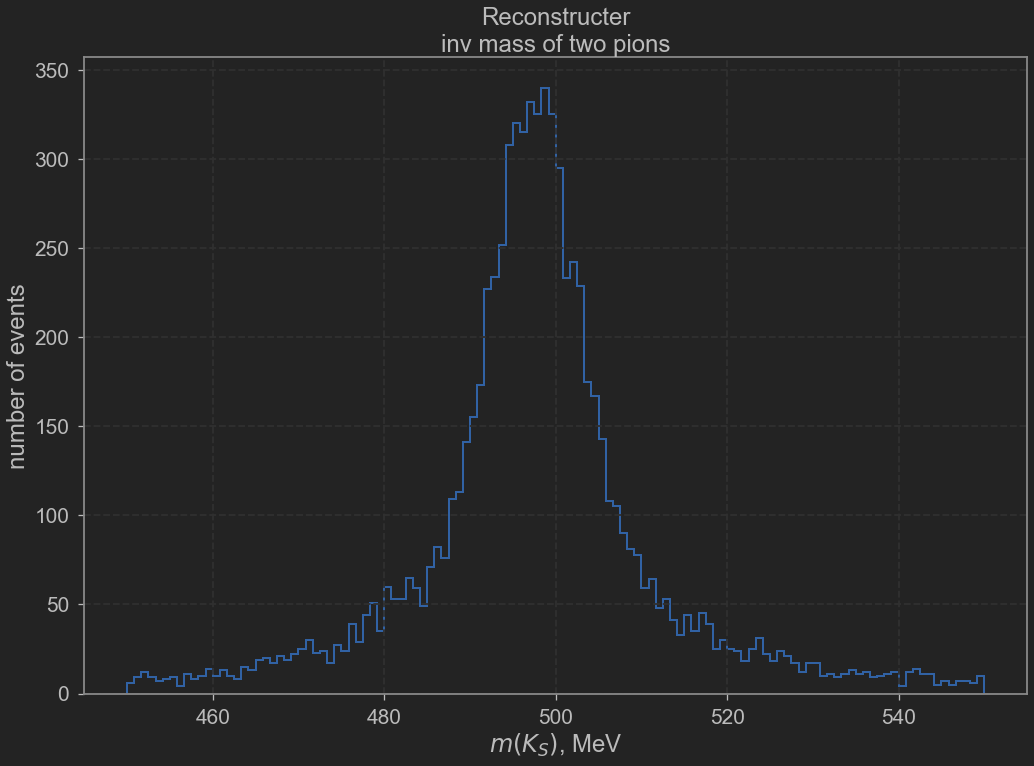

In [192]:
m = vec4_table_rec
plt.hist(m.M, bins=120, range=(450, 550), histtype='step', alpha=0.8, lw=2, density=False);
my_style('Reconstructer\ninv mass of two pions', '$m(K_S)$, MeV', 'number of events', '--')
# plt.savefig('outputs/images/7_rec_K.png')

Постарался и выделил массу KS из привязанных к генератору пионов.

Теперь отфитирую эту штуку двумя гауссами

In [193]:
import iminuit
import probfit as pf

In [194]:
#гаусс + гаусс
def gauss2(x, mu, mu2, sigma1, sigma2, f):
    return f*pf.gaussian(x, mu, sigma1) + (1-f)*pf.gaussian(x, mu2, sigma2)
def const(x):
    return 1

mass_bound=(470,530)
norm_sig = pf.rename( pf.Normalized( gauss2, mass_bound ), ['x', 'M1','M2', 'S1', 'S2', 'f'] )
# norm_bkg = pf.rename( pf.Normalized( gauss, mass_bound ), ['x', 'M1', 'S2'] )

ext_sig = pf.Extended(norm_sig, extname='N1')
# ext_bkg = pf.Extended(norm_bkg, extname='N2')

pdf = ext_sig#pf.AddPdf(ext_sig, ext_bkg)

limits = {
    "limit_M1": [497, 498],
    "limit_S1": [1, 15],
    "limit_N1": [1000, 100000],
    "limit_M2": [490, 500],
    "limit_S2": [3, 25],
#     "limit_N2": [0, 7000],
    "limit_f": [0, 1],
}
pf.describe(pdf)

['x', 'M1', 'M2', 'S1', 'S2', 'f', 'N1']

In [195]:
def fitter(dic, nbins):
    
    likelihood = pf.BinnedChi2(pdf, dic, bins=nbins, bound=mass_bound)
#     likelihood = pf.UnbinnedLH(pdf, dic, extended=True, extended_bound=mass_bound)
    
    initial_par_values = {"M1": 497.6, "S1": 4.26, "N1": 7000, "S2":17,"M2": 497.6, 'f':0.5}# "N2": 1,  
    mt = iminuit.Minuit(likelihood, **initial_par_values, **limits, pedantic=False)
    mt.migrad();
    
    likelihood.draw(minuit=mt)#, bins=nbins, bound=mass_bound)
    return mt, likelihood

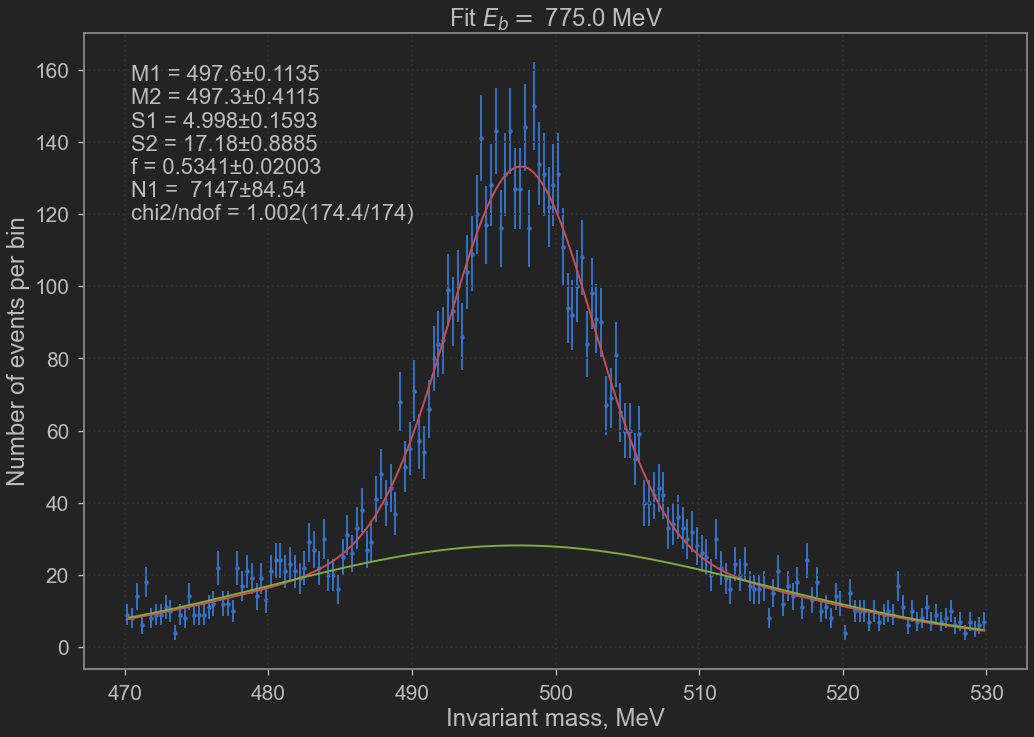

In [200]:
nbins = 180
mt, lk = fitter(m.M.values, nbins)
vals = mt.values.values()
vals[-1] *= (1-vals[-2])*(mass_bound[1]-mass_bound[0])/nbins
vals[-2] = 0
pf.draw_pdf(pdf, arg=vals, bound=mass_bound);
my_style(f'Fit $E_b = $ {mc_minus.emeas.mean()} MeV', 'Invariant mass, MeV', 'Number of events per bin')
# plt.savefig('outputs/images/7_fit_K_775.png')

In [197]:
e = [812.5, 550, 687.5, 935, 625, 950, 775]
s1 = [5.249, 4.034, 4.157, 6.075, 4.164, 5.163, 4.998]
ds1 = [0.025, 0.080, 0.11, 0.276, 0.094, 0.31, 0.16]
s2 = [14.94, 14.4, 14.33, 19.34, 14.64, 16.38, 17.18]
ds2 = [0.67, 0.598, 0.50, 1.503, 0.589, 0.795, 0.89]
f = [0.4619, 0.6924, 0.57, 0.476, 0.651, 0.378, 0.5341]
df = [0.032, 0.013, 0.017, 0.03, 0.0148, 0.03, 0.02]

In [202]:
mt.matrix(correlation=True)

--------------------------------------------------
|    |     M1     M2     S1     S2      f     N1 |
--------------------------------------------------
| M1 |  1.000 -0.279  0.042  0.045  0.026 -0.000 |
| M2 | -0.279  1.000 -0.091 -0.179 -0.086 -0.000 |
| S1 |  0.042 -0.091  1.000  0.680  0.795 -0.000 |
| S2 |  0.045 -0.179  0.680  1.000  0.781 -0.000 |
|  f |  0.026 -0.086  0.795  0.781  1.000 -0.000 |
| N1 | -0.000 -0.000 -0.000 -0.000 -0.000  1.000 |
--------------------------------------------------

<ErrorbarContainer object of 3 artists>

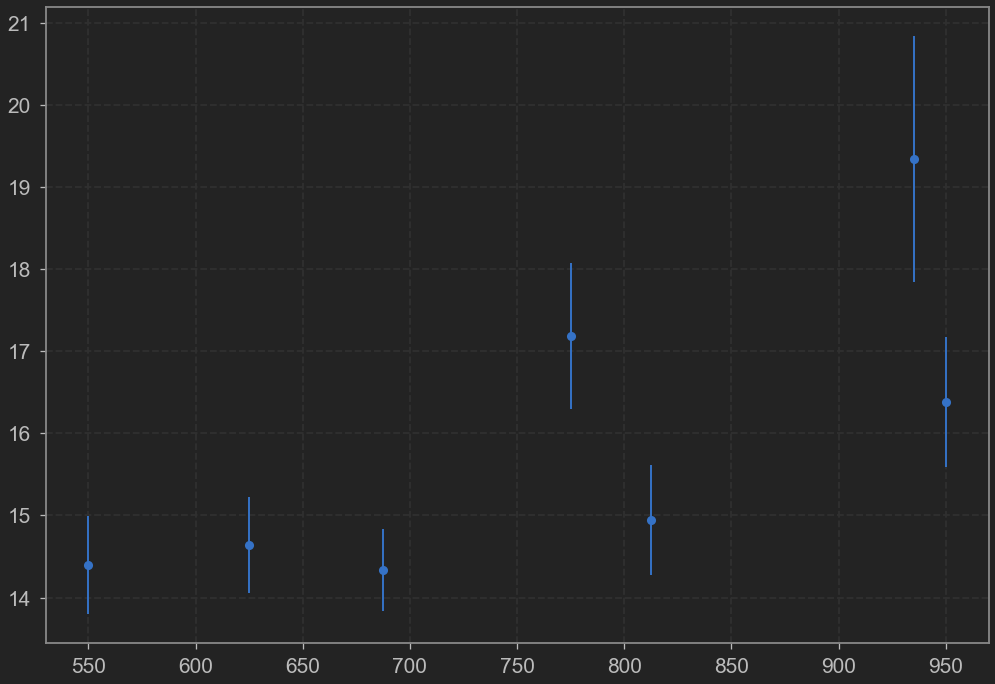

In [201]:
plt.errorbar(x=e, y=s2, yerr=ds2, fmt='o')

# 2/27-28/20
___
Метод сайд-бендов не прокатывает, так как в них есть сигнал, поэтому ищу распределение нефизического фона

In [37]:
it = uproot.pandas.iterate('../../outputs/others/underThreshold/*.root', treepath='pic_mom')

In [38]:
unph_bkg = pd.concat([i for i in it], ignore_index=True)

In [39]:
unph_bkg

,align,momentum,mass,passed
0,0.999892,418.163818,3.488998,False
1,0.992468,627.972290,40.252934,False
2,0.999968,471.809113,4.114306,False
3,0.999943,490.961884,15.202196,False
4,0.999997,482.764221,15.375327,False
...,...,...,...,...
1424,0.982825,61.044605,421.889160,False
1425,0.999975,36.624336,543.150757,False
1426,-0.985567,37.716602,498.424438,False
1427,0.815877,20.443487,534.720520,False


In [40]:
unph_bkg = unph_bkg.query('align>0.8')

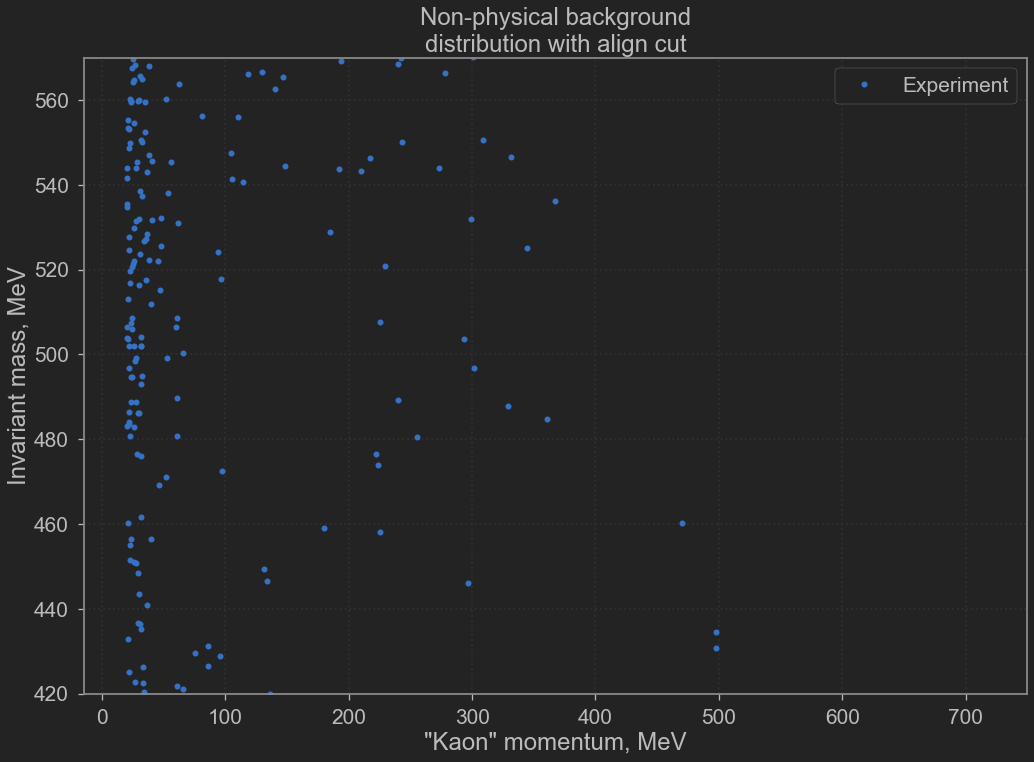

In [51]:
plt.plot(unph_bkg.momentum, unph_bkg.mass, '.', label='Experiment', ms=12)
plt.ylim(420, 570);
# plt.text(500, 530, "$E_{beam}$ = 490 MeV\nRHO2013,18\nL = 100+100 nb")
plt.legend();
my_style('Non-physical background\ndistribution with align cut', '"Kaon" momentum, MeV', 'Invariant mass, MeV')
# plt.savefig('outputs/images/7_nonphys_bkg.png')

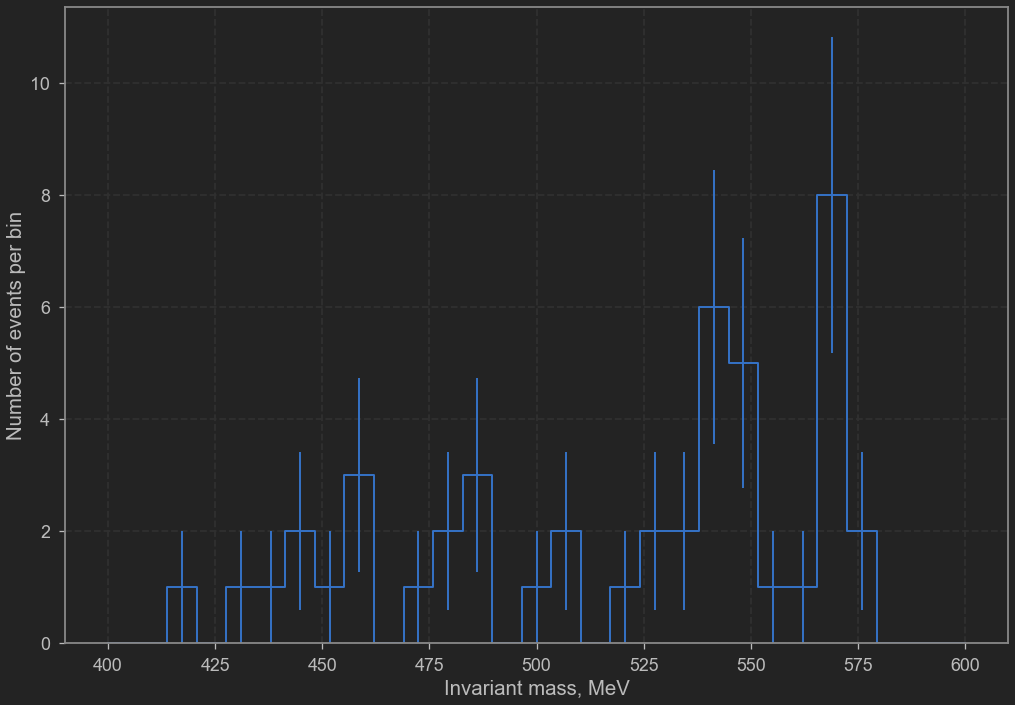

In [108]:
hist, bins = np.histogram(unph_bkg.query('momentum>100').mass, bins=np.linspace(400, 600, 30));
hep.histplot(hist, bins, yerr=True);
plt.ylabel('Number of events per bin');
plt.grid(linestyle='--')
plt.xlabel('Invariant mass, MeV');
# plt.savefig('outputs/images/7_nonphys_bkg_minv.png')

In [109]:
import probfit as pf
from iminuit import Minuit

In [110]:
def line(x, c):
    return c

chi2 = pf.BinnedChi2(line, unph_bkg.mass, bound=(430, 520), bins=20)

In [111]:
m = Minuit(chi2)
m.migrad()

------------------------------------------------------------------
| FCN = 21.11                   |      Ncalls=13 (13 total)      |
| EDM = 5.6E-19 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | c    |   0.65    |   0.09    |            |            |         |         |       |
------------------------------------------------------------------------------------------

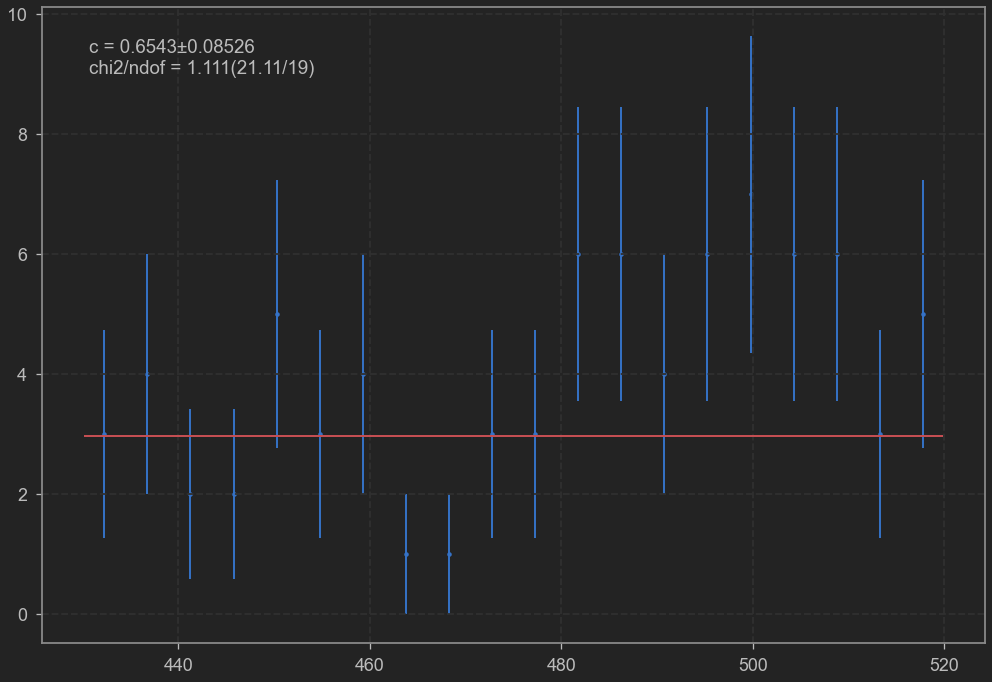

In [112]:
chi2.draw(m);

## Физический фон
____
Раз уж я этим занялся, то посмотрю на распределение физического фона для моих событий

Для этого я намоделировал 100 000 событий на мультиадронном генераторе на энергии 1.9 ГэВ, а потом нашёл кучу уже сгенерированных файлов на [Cmd3Off](https://cmd.inp.nsk.su/~cmd3off/) по 300 000 событий

In [63]:
ebeams = [749.55, 825.05, 950.00, 1003.31]
ebeam = ebeams[3]
mh_tree = uproot.open(glob(f"../../outputs/others/multihadrons/{ebeam}*.root")[0])['pic_mom']

In [64]:
mh = mh_tree.pandas.df(flatten=False).query('align>0.8')

In [65]:
def simtypes_to_process(st):
    st = st.copy()
    parts_dict = {111:'$\pi^0$', 211:'$\pi^+$', -211: '$\pi^-$', 321: '$K^+$', -321: '$K^-$', 310:'$K_S$', 130:'$K_L$', \
                  2212:'$p^+$', -2212:'$p^-$', 221:'$\eta$'}
    num_particles = list(map(lambda x: ''.join(list(map(lambda y: parts_dict[y], x))) , st)) 
    return num_particles

In [66]:
mh['process_type'] = simtypes_to_process(mh['simtypes'])
mh['is_kskl'] = (mh['process_type'] == '$K_L$$K_S$')

In [67]:
mh.head()

,align,momentum,mass,passed,simtypes,process_type,is_kskl
entry,,,,,,,
0,0.999933,257.480072,496.220856,False,"[321.0, 310.0, -211.0, 111.0]",$K^+$$K_S$$\pi^-$$\pi^0$,False
1,0.999489,566.411133,492.487274,False,"[310.0, 130.0, 211.0, -211.0]",$K_S$$K_L$$\pi^+$$\pi^-$,False
2,0.998653,440.097198,501.632965,False,"[310.0, 130.0, 211.0, -211.0]",$K_S$$K_L$$\pi^+$$\pi^-$,False
4,0.999965,727.848267,499.147552,False,"[130.0, 310.0, 111.0, 111.0]",$K_L$$K_S$$\pi^0$$\pi^0$,False
5,0.998076,209.462799,479.770203,False,"[310.0, 130.0, 211.0, -211.0]",$K_S$$K_L$$\pi^+$$\pi^-$,False


Составлю некоторый рейтинг процессов, которые пытаются пролезть

In [68]:
mh.groupby('process_type').agg({'momentum':'count'}).sort_values(by='momentum', ascending=False)

,momentum
process_type,
$K^+$$K_S$$\pi^-$$\pi^0$,2270
$K_L$$K_S$$\pi^0$$\pi^0$,1239
$K_S$$K_L$$\pi^+$$\pi^-$,760
$\pi^+$$K_S$$K^-$,327
$\pi^-$$K_S$$K^+$,315
$K_S$$K_S$$\pi^+$$\pi^-$,214
$K_L$$K_S$,186
$\pi^-$$\pi^+$$\pi^-$$\pi^+$$\pi^0$$\pi^0$,14
$K^-$$K_L$$\pi^+$$\pi^0$,12


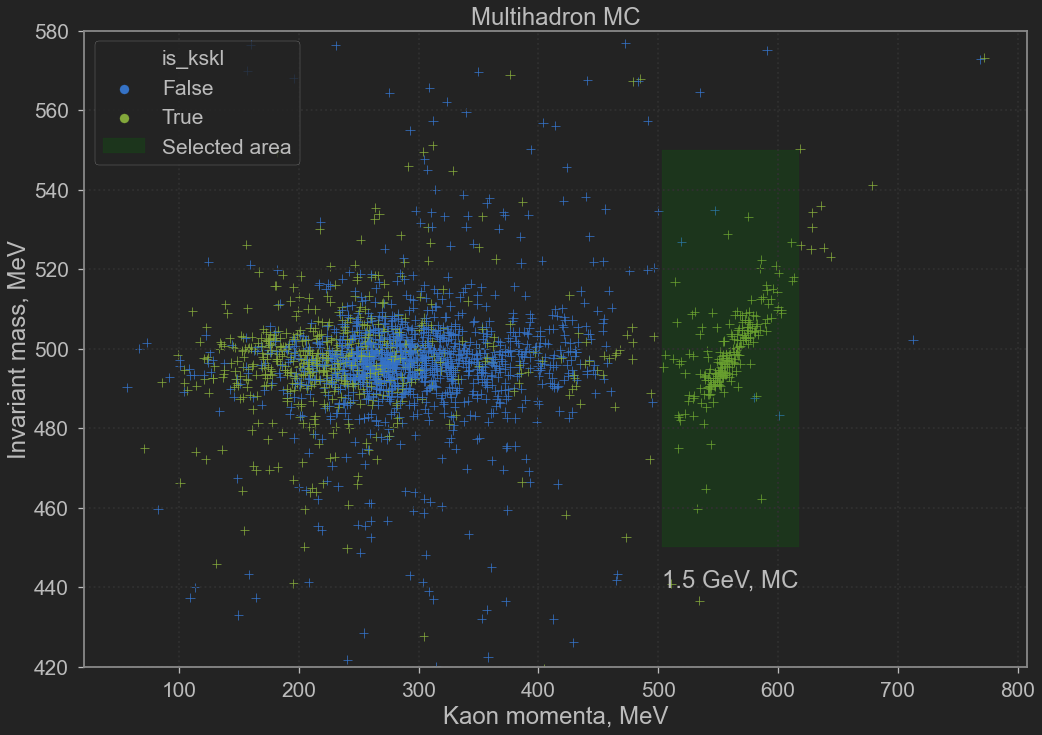

In [61]:
p_cut = 2 * (0.0869 * ebeam - 36.53)
p0 = np.sqrt(ebeam**2 - 497.6**2)

sns.scatterplot(data=mh, x='momentum', y='mass', hue='is_kskl', marker="+", legend='brief')
plt.fill_between([p0-p_cut, p0+p_cut], [450, 450], [550, 550], color='green', alpha=0.2, label='Selected area')
plt.grid(linestyle=":")
# plt.xlim(50, 350);
plt.ylim(420, 580);
plt.text(p0-p_cut, 440, f"{ebeam*2e-3:.1f} GeV, MC", size=24);
plt.title('Multihadron MC')
plt.xlabel('Kaon momenta, MeV');
plt.ylabel('Invariant mass, MeV');
plt.legend(frameon=True, loc='upper left');
# plt.savefig('outputs/images/7_invMass_mom_dist_19_1.5GeV.png')

Нужно отметить, что событий распределённых равномерно по массе и близко к нулю по импульсу в физическом моделировании нет

Ну и финальная картинка: распределение по инвариантной массе

In [59]:
print('Found events:', len(mh.query('abs(mass-500)<50&passed')))
print('Found events KSKL:', len(mh.query('is_kskl==True&abs(mass-500)<50&passed')))
print('Found events non-KSKL:', len(mh.query('is_kskl==False&abs(mass-500)<50&passed')))

Found events: 219
Found events KSKL: 215
Found events non-KSKL: 4


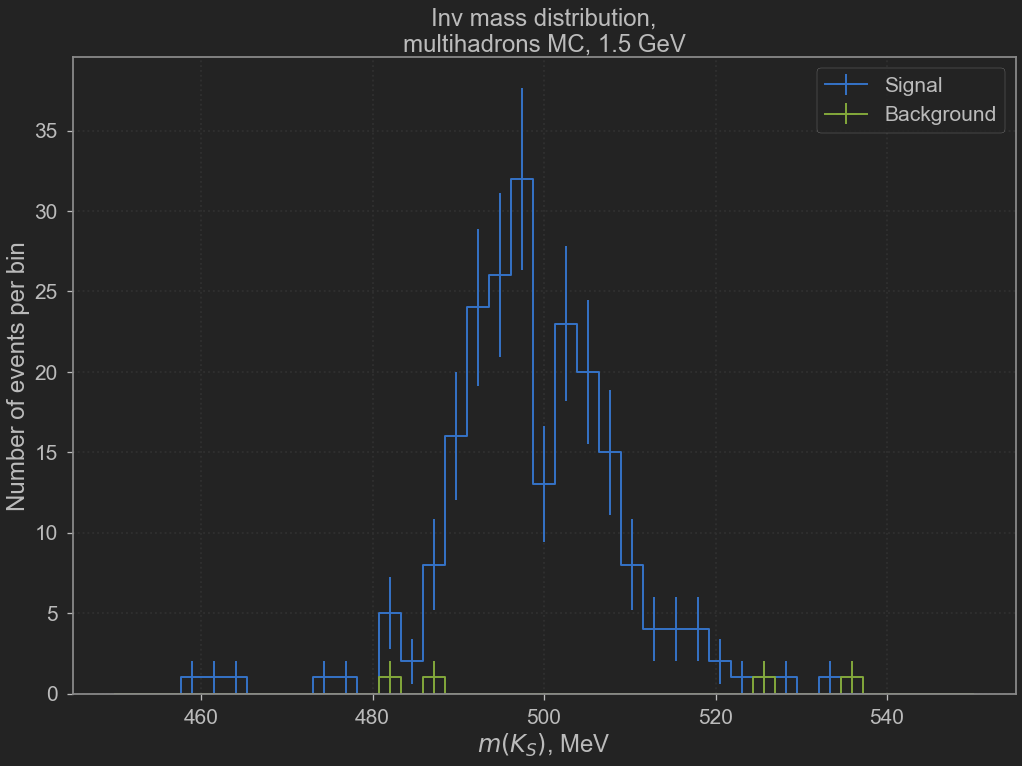

In [62]:
bins = np.linspace(450, 550, 40)
h1, _ = np.histogram(mh.query('is_kskl==True&passed').mass, bins=bins)
h2, _ = np.histogram(mh.query('is_kskl==False&passed').mass, bins=bins)

hep.histplot([h1, h2], bins=bins, stack=False, yerr=True, label=['Signal',"Background"])
my_style(f'Inv mass distribution,\nmultihadrons MC, {ebeam*0.002:.1f} GeV', \
         '$m(K_S)$, MeV', "Number of events per bin", ':')
plt.legend(frameon=True)
# plt.savefig('outputs/images/7_invMass_inv_dist_19_1.5GeV.png')

Посмотрю, есть ли в моём фоне космика

In [125]:
cosmic_tree = uproot.open("../../outputs/others/cosmic.root")['pic_mom']

In [126]:
cosmic_df = cosmic_tree.pandas.df(flatten=False)

In [127]:
len(cosmic_df)

0

Видно, что космика даже не пытается показаться

In [128]:
ee_tree = uproot.open("../../outputs/others/ee_1.9.root")['pic_mom']
ee_df = cosmic_tree.pandas.df(flatten=False)

In [129]:
len(ee_df)

0

$e^+e^-$ у меня тоже нету

$K^+K^-$ тоже проверил, нету